<a href="https://colab.research.google.com/github/laiyenglee/Database/blob/main/PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.preprocessing import normalize
from typing import Tuple

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('gdrive/My Drive/Bloodtype.txt', sep='\t', header=None)
data.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,A
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,A
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,A
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,A
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,A


In [ ]:
class Particle:
    def __init__(self, n_clusters, data, use_kmeans=True, w=0.72, c1=2.05, c2=2.05):
        self.n_clusters = n_clusters
        if use_kmeans:
            k_means = KMeans(n_clusters=self.n_clusters)
            k_means.fit(data)
            self.centroids_position = k_means.cluster_centers_
        else:
            self.centroids_position = data[np.random.choice(list(range(len(data))), self.n_clusters)]

        # each cluster has a centroid which is the point that represents that cluster
        # assign k random data to k centroids
        self.pbest_value = np.inf
        # personal best position for all the centroids so far
        self.pbest_position = self.centroids_position.copy()
        self.velocity = np.zeros_like(self.centroids_position)
        # best data clustering so far
        self.pbest_clustering = None
        # pso params
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def update_pbest(self, data: np.ndarray):
        """
        Updates personal best score based on the fitness function mentioned in the paper (Equation(4))
        :return:
        """
        # finding out which data points belongs to which cluster
        # for that we have to find the distance between the data points and the centroids.
        distances = self.get_distances(data=data)
        # the minimum distance between a data point and a centroid indicates that, the point belongs to that cluster.
        clusters = np.argmin(distances, axis=0)  # shape: (len(data),)
        clusters_ids = np.unique(clusters)

        # This is for when the algorithm generates less than n clusters
        # So we find the cluster id that is missed and generate the centroid position with a random data point
        while len(clusters_ids) != self.n_clusters:
            deleted_clusters = np.where(np.isin(np.arange(self.n_clusters), clusters_ids) == False)[0]
            self.centroids_position[deleted_clusters] = data[np.random.choice(list(range(len(data))), len(deleted_clusters))]
            distances = self.get_distances(data=data)
            clusters = np.argmin(distances, axis=0)
            clusters_ids = np.unique(clusters)

        new_value = self.fitness_function(clusters=clusters, distances=distances)
        if new_value < self.pbest_value:
            self.pbest_value = new_value
            self.pbest_position = self.centroids_position.copy()
            self.pbest_clustering = clusters.copy()

    def update_velocity(self, gbest_position: np.ndarray):
        """
        Updates new velocity based on the current velocity, personal best position so far, and the swarm (global) best
        position so far.
        :param gb_pos: vector of best centroid positions among all particles so far
        :return:
        """
        self.velocity = self.w * self.velocity + \
                        self.c1 * np.random.random() * (self.pbest_position - self.centroids_position) + \
                        self.c2 * np.random.random() * (gbest_position - self.centroids_position)

    def move_centroids(self, gbest_position):
        self.update_velocity(gbest_position= gbest_position)
        new_position = self.centroids_position + self.velocity
        self.centroids_position = new_position.copy()

    def get_distances(self, data: np.ndarray) -> np.ndarray:
        """
        Calculates the Euclidean distance between data and centroids
        :param data:
        :return: distances: a numpy array of distances (len(centroids) x len(data))
        """
        distances = []
        for centroid in self.centroids_position:
            # calculate euclidean distance --> square root of sum of absolute squares
            d = np.linalg.norm(data - centroid, axis=1)
            distances.append(d)
        distances = np.array(distances)
        return distances

    def fitness_function(self, clusters: np.ndarray, distances: np.ndarray) -> float:
        """
        Calculates the fitness function ( Equation 4)
        i is the index of particle
        j is the index of clusters in the particle i
        p is the vector of the input data indices belonging the cluster[ij]
        z[p] is the vector of the input data belonging the cluster[ij]
        d is a vector of distances between z(p) and centroid j
        :param clusters:
        :param distances:
        :return: J:
        """
        J = 0.0
        for i in range(self.n_clusters):
            p = np.where(clusters == i)[0]
            if len(p):
                d = sum(distances[i][p])
                d /= len(p)
                J += d
        J /= self.n_clusters
        return J

In [ ]:
class PSOClustering:
    def __init__(self, n_clusters: int, n_particles: int, data: np.ndarray, hybrid=True, w=0.72, c1=2.05, c2=2.05):
        """
        Initializes the swarm.
        :param n_clusters: number of clusters
        :param n_particles: number of particles
        :param data: ( number_of_points x dimensions)
        :param hybrid: bool : whether or not use kmeans as seeding
        :param w:
        :param c1:
        :param c2:
        """
        self.n_clusters = n_clusters
        self.n_particles = n_particles
        self.data = data

        self.particles = []
        # for storing global best
        self.gbest_position = None
        self.gbest_value = np.inf
        # global best data clustering so far
        # for each data point will contain the cluster number
        self.gbest_clustering = None

        self.generate_particles(hybrid, w, c1, c2)

    def print_initial(self, iteration, plot):
        print('Initialing swarm with', self.n_particles, 'PARTICLES, ', self.n_clusters, 'CLUSTERS with', iteration,
              'MAX ITERATIONS and with PLOT =', plot, '***')
        print('Data=', self.data.shape[0], 'points in', self.data.shape[1], 'dimensions')

    def generate_particles(self, hybrid: bool, w: float , c1: float, c2: float ):
        """
        Generates particles with k clusters and t-dimensional points
        :return:
        """
        for i in range(self.n_particles):
            particle = Particle(n_clusters=self.n_clusters, data=self.data, use_kmeans=hybrid, w=w, c1=c1, c2=c2)
            self.particles.append(particle)

    def update_gbest(self, particle):
        if particle.pbest_value < self.gbest_value:
            self.gbest_value = particle.pbest_value
            self.gbest_position = particle.pbest_position.copy()
            self.gbest_clustering = particle.pbest_clustering.copy()

    def start(self, iteration=2000, plot=False) -> Tuple[np.ndarray, float]:
        """
        :param plot: = True will plot the global best data clusters
        :param iteration: number of max iteration
        :return: (best cluster, best fitness value)
        """
        self.print_initial(iteration, plot)
        progress = []
        # Iterate until the max iteration
        for i in range(iteration):
            if i % 400 == 0:
                clusters = self.gbest_clustering
                print('iteration', i, 'GBest =', self.gbest_value)
                print('best clusters so far = ', clusters)
                if plot:
                    centroids = self.gbest_position
                    if clusters is not None:
                        plt.scatter(self.data[:, 0], self.data[:, 1], c=clusters, cmap='plasma')
                        plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=400, alpha=0.5)
                        plt.show()
                    else:  # if there is no clusters yet ( iteration = 0 ) plot the data with no clusters
                        plt.scatter(self.data[:, 0], self.data[:, 1])
                        plt.show()

            for particle in self.particles:
                particle.update_pbest(data=self.data)
                self.update_gbest(particle=particle)

            for particle in self.particles:
                particle.move_centroids(gbest_position=self.gbest_position)
            progress.append([self.gbest_position, self.gbest_clustering, self.gbest_value])

        print('Finished!')
        return self.gbest_clustering, self.gbest_value

In [ ]:
plot = True
data = pd.read_csv('gdrive/My Drive/Bloodtype.txt', sep='\t',error_bad_lines=False, header=None)
clusters = data[7].values
data = data.drop([7], axis=1)

Initialing swarm with 50 PARTICLES,  4 CLUSTERS with 2000 MAX ITERATIONS and with PLOT = True ***
Data= 200 points in 2 dimensions
iteration 0 GBest = inf
best clusters so far =  None


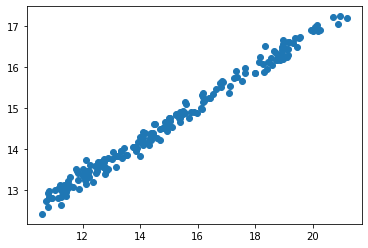

iteration 400 GBest = 0.6374879366125505
best clusters so far =  [1 2 2 2 1 2 2 2 1 1 1 2 2 2 2 2 2 1 2 0 2 2 1 0 2 1 0 0 2 2 0 1 2 2 2 1 1
 1 2 2 2 2 0 1 2 2 1 2 2 2 2 1 2 2 2 2 2 2 1 0 0 0 0 2 0 0 2 2 2 0 3 1 1 3
 1 1 1 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 0 2 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]


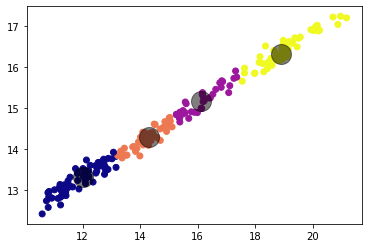

iteration 800 GBest = 0.6341769347983593
best clusters so far =  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 0 0 2 0 0 2 2 2 2 2 2
 1 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 3 0 0 0 0 2 2 2 0 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 2 2 2 1 2 2 2 0 0 0 0 3 3 3 0
 0 3 3 0 0 3 3 3 3 0 3 3 0 0 0 0 3 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 3 0 0 3 0
 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0]


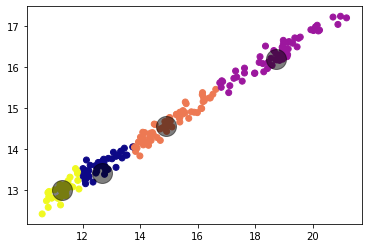

iteration 1200 GBest = 0.6216572675082859
best clusters so far =  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 0 0 2 0 0 2 2 2 2 2 2
 1 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 3 0 0 0 0 2 2 2 0 1 1 1 1
 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 2 2 2 1 2 2 2 0 0 0 0 0 3 3 0
 0 3 0 0 0 3 3 3 3 0 0 3 0 0 0 0 3 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 3 0 0 3 0
 3 0 3 3 3 3 3 3 3 0 0 0 0 0 0]


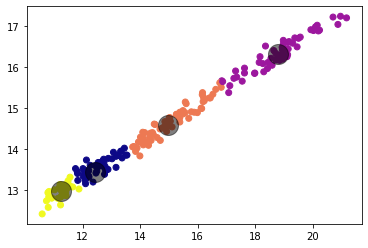

iteration 1600 GBest = 0.6190205159855378
best clusters so far =  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 0 0 2 0 0 2 2 2 2 2 2
 1 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 3 0 0 0 0 2 2 2 0 1 1 1 1
 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 2 2 2 1 2 2 2 0 0 0 0 0 3 3 0
 0 3 3 0 0 3 3 3 3 0 0 3 0 0 0 0 3 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 3 0 0 3 0
 3 0 3 3 3 3 3 3 3 0 0 0 0 0 0]


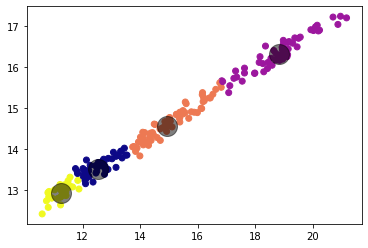

Finished!


(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 0, 0, 0, 0,
        2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 0, 3, 0, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
        0, 0]), 0.618768095739989)

In [ ]:
# if you want to plot you can only show 2 points! so will use 2 points of data
if plot:
    data = data[[0, 1]]
# convert to numpy 2d array
data = data.values
pso = PSOClustering(n_clusters=4, n_particles=50, data=data, hybrid=True)
pso.start(iteration=2000, plot=plot)


In [ ]:
pso_kmeans= KMeans(n_clusters=4)
pso_kmeans.fit(data)
y_pred=pso_kmeans.predict(data) 
data=np.argmax(data, axis=1)

In [ ]:
print('F1 score:',f1_score(data,y_pred,pos_label='positive',average='macro'))

F1 score: 0.25058339052848316


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [ ]:
print('Accuracy:',precision_score(data,y_pred,pos_label='positive',average='macro'))

Accuracy: 0.390625


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [ ]:
print('Recall:', recall_score(data,y_pred,pos_label='positive',average='macro'))

Recall: 0.1847301778715707


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# For showing the actual clusters
mapping = {'A': 0, 'B': 1, 'AB': 2, 'O':3}
clusters = np.array([mapping[x] for x in clusters])
print('Actual classes = ', clusters)

Actual classes =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
